## 1. Pre-processing

In [ ]:
# Import the essentials library
from sys import stdout

import random
import numpy as np
import torch
from torch import nn

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix

# Correct way for SymPy 1.0+
!pip install --upgrade "sympy==1.12"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 116.8 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cu

In [ ]:
# Clone github repo for data
!git clone https://github.com/thilowrona/seismic_deep_learning

Cloning into 'seismic_deep_learning'...
remote: Enumerating objects: 862, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 862 (delta 55), reused 68 (delta 31), pack-reused 750 (from 1)
Receiving objects: 100% (862/862), 62.82 MiB | 11.30 MiB/s, done.
Resolving deltas: 100% (422/422), done.


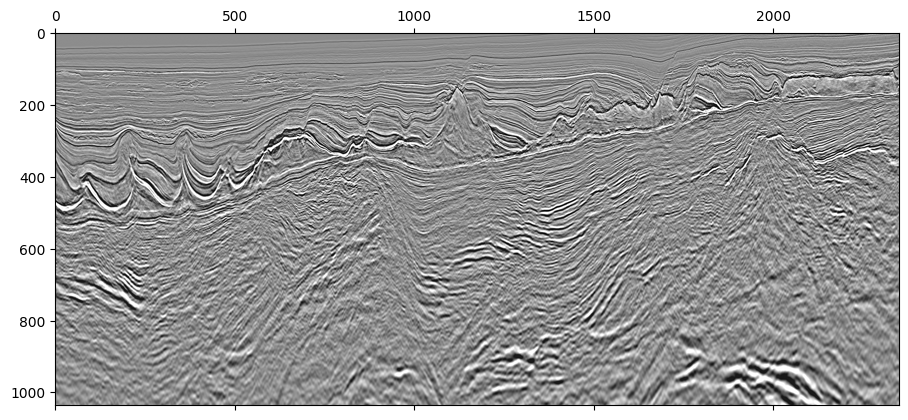

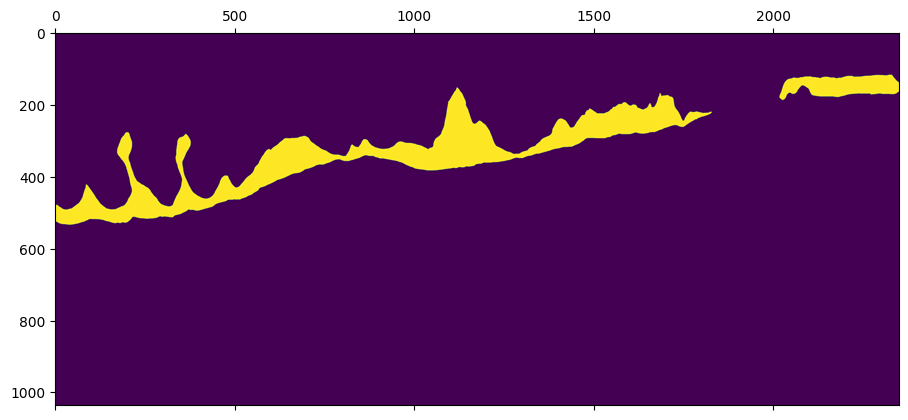

In [ ]:
# Load seismic data image
data = mpimg.imread('seismic_deep_learning/tutorial-01/seismic.tif')

# Kepp only first channel color (grayscale) and make it value range from 0 to 1 only by devide 255
data = data[:,:,:1] / 255
data

# Load segmentation mask and make a copy
mask = mpimg.imread('seismic_deep_learning/tutorial-01/mask.tif').copy()

# Again normalize from 0 to 1
# Since mask has a range [0, 255] or float numbers -> we gotta use min max formula make it compatible for the model
mask = (mask - mask.min()) / (mask.max() - mask.min())

# Visualize it
plt.matshow(data[:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)

# Display mask in same way
plt.matshow(mask, interpolation='spline16', aspect=1)

# Display both
plt.show()

In [ ]:
# Since we dont have any image that have mask we gotta maximize this one and make use of small patches to train model
# Set parameter for the training
num_train = 5000
num_val = 1000
dim = (64,64,1)

# Function to extract random patchs from seismic data
def patches(data, mask, patch_num, dim):
  # Allocate arrays for image pathces (X) and their corresponding label (y)
  X = np.empty((patch_num, * dim)) # Shape: (patch_num, height, width, color)
  y = np.empty((patch_num))

  # Dimension of input seismic data
  t_max, x_max, _ = data.shape

  for n in range(patch_num):
    # Randomly select a center point in data
    x_n = random.randint(dim[1] // 2, x_max -dim[1] // 2)
    t_n = random.randint(dim[0] // 2, t_max - dim[0] //2 )

    # Extract a patch centered at selected point
    X[n, :, :, 0] = data[t_n - dim[0] // 2 : t_n + dim[0] //2,
                         x_n - dim[1] // 2 : x_n + dim[1] // 2, 0]

    # Determine label at center pixel from mask
    y[n] = mask[t_n, x_n]

  return X, y

# Generate training patches from lef side
X_train, y_train = patches(data[:,: 1200], mask[:, : 1200], num_train, dim)

# Generate validation pathces from right side
X_val, y_val = patches(data[:, 1200:], mask[:, 1200:], num_val, dim)


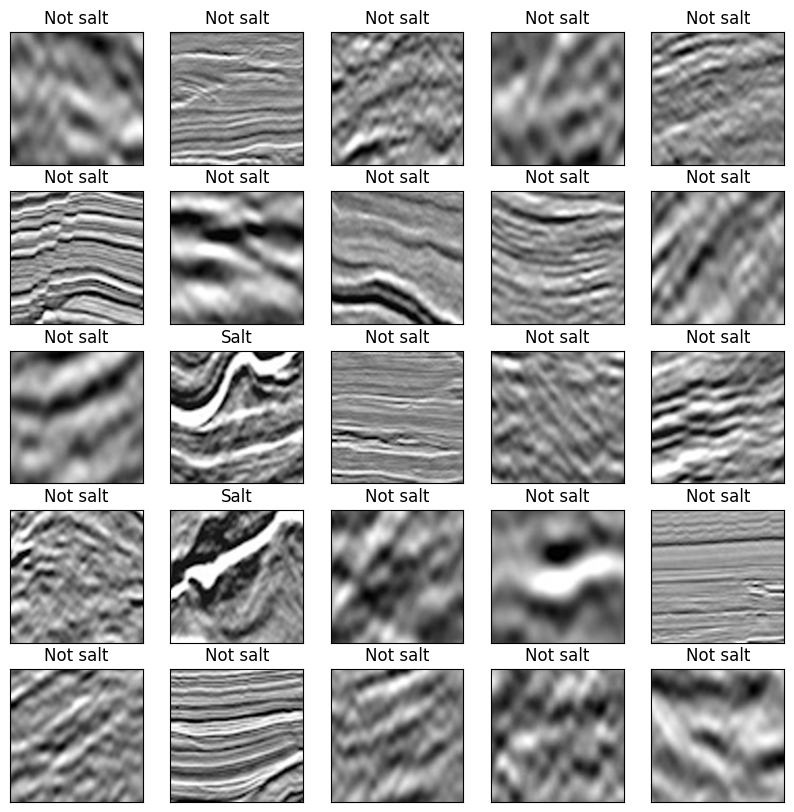

In [ ]:
# Visualize first patches that we made
fig, axs = plt.subplots(5,5,figsize=(10,10))

k = 0 # Patches index

# Loop over rows and columns of subplot grid
for n in range(5):
  for m in range(5):
    # Show the k-th patch as a grayscale image
    axs[n, m].imshow(X_train[k, :, :, 0],
                     interpolation = 'spline16',
                     cmap=plt.cm.gray,
                     aspect = 1)

    # Remove axis for better visual
    axs[n,m].set_xticks([])
    axs[n,m].set_yticks([])

    # Display the class label as the title of subplot
    if y_train[k] == 1:
      axs[n, m].set_title('Salt')
    else:
      axs[n, m].set_title('Not salt')

    k += 1

## 2. Training

### 2.1 Define the architecture

In [ ]:
# CNN for binary classification seismic image patches
class Seismic(nn.Module):
  def __init__(self,
               input_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = 16,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.2),

        nn.Conv2d(in_channels= 16,
                  out_channels=32,
                  kernel_size= 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.2),

        nn.Conv2d(in_channels= 32,
                  out_channels=64,
                  kernel_size= 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.2)
    )

    self.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(64 * 8 * 8, 512),
    nn.ReLU(),
    nn.Linear(512, 2)
    )

  def forward(self ,x):
      x = self.conv_block_1(x)
      x = self.classifier(x)
      return x

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Create data loaders and convert numpy arrays to pytorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype = torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Permute data tobe (N, C, H, W ) for conv2d layer
X_train_tensor = X_train_tensor.permute(0, 3, 1, 2)
X_val_tensor = X_val_tensor.permute(0, 3, 1, 2)

# Create tensor dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create dataloader
BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle=True)

val_dataloader = DataLoader(val_dataset,
                            batch_size = BATCH_SIZE,
                            shuffle = False)

print(f"Shape of a training batch (X): {next(iter(train_dataloader))[0].shape}")
print(f"Shape of a training batch (y): {next(iter(train_dataloader))[1].shape}")

Shape of a training batch (X): torch.Size([32, 1, 64, 64])
Shape of a training batch (y): torch.Size([32])


In [ ]:
# Create train, test functions and the real training part

# Train step
def train_step(model : torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  # Put the model in training mode
  model.train()

  # Setup train loss and train accuracy initial values
  train_loss, train_accuracy = 0, 0

  # Loop through data loader and data batches
  for batch, (X,y) in enumerate(data_loader):
    # Send data to target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimzer step
    optimizer.step()

    # Calculate and accumulate accuracy metric accross all batches
    y_pred_class = torch.argmax(y_pred, dim=1)
    train_accuracy += (y_pred_class == y).sum(). item() / len(y)

  # Adjust metrics to get average loss and average accuracy per batch
  return train_loss / len(data_loader), train_accuracy / len(data_loader)


# Test step
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
  test_loss, test_acc = 0, 0

  model.eval()

  # Use inference mode
  with torch.inference_mode():
    for batch, (X,y) in enumerate(data_loader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass (output raw logits)
      test_pred_logits = model(X)

      # 2. Calculate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # 3. Calculate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

    # Calculate the test loss average per batch
    test_loss /= len(data_loader)

    # Calculate the test loss average per batch
    test_acc /= len(data_loader)

  # Print out
  print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")
  return test_loss, test_acc

# The real training step that combine 2 above
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int,
          device = device):
  results = {
      "train_loss" : [],
      "train_accuracy": [],
      "test_loss": [],
      "test_acc": []
  }

  for epoch in range(epochs):
    train_loss, train_accuracy = train_step(
        model = model,
        data_loader = train_dataloader,
        loss_fn=loss_fn,
        optimizer = optimizer,
        device = device
    )
    test_loss, test_acc = test_step(
        model = model,
        data_loader = test_dataloader,
        loss_fn = loss_fn,
        device = device
    )

    print(f"Epoch {epoch+1}: "
          f"Train loss: {train_loss:.4f} | Train acc: {train_accuracy:.4f} | "
          f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    results["train_loss"].append(train_loss)
    results["train_accuracy"].append(train_accuracy)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [ ]:
# Train for 5 epoch
NUM_EPOCHS = 10

# Recreate an instance of tinyVGG
model_0 = Seismic (input_shape = 1).to(device)

# Setup loss function and optimzer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(),
                             lr = 0.001,
                             weight_decay=1e-4)

# Start the timer
from timeit import default_timer as timer
start_timer = timer()

# Train model_0
model_0_results = train(model = model_0,
                        train_dataloader = train_dataloader,
                        test_dataloader = val_dataloader,
                        optimizer = optimizer,
                        loss_fn=loss_fn,
                        epochs = NUM_EPOCHS)

# End the timer and print out how long
end_timer = timer()
print(f"Total training time: {end_timer - start_timer:.3f} seconds")

Test loss: 0.25936 | Test acc: 0.95%
Epoch 1: Train loss: 0.2521 | Train acc: 0.9218 | Test loss: 0.2594 | Test acc: 0.9531
Test loss: 0.20774 | Test acc: 0.95%
Epoch 2: Train loss: 0.2182 | Train acc: 0.9313 | Test loss: 0.2077 | Test acc: 0.9473
Test loss: 0.21634 | Test acc: 0.95%
Epoch 3: Train loss: 0.1848 | Train acc: 0.9389 | Test loss: 0.2163 | Test acc: 0.9531
Test loss: 0.20067 | Test acc: 0.94%
Epoch 4: Train loss: 0.1773 | Train acc: 0.9405 | Test loss: 0.2007 | Test acc: 0.9434
Test loss: 0.22009 | Test acc: 0.95%
Epoch 5: Train loss: 0.1389 | Train acc: 0.9498 | Test loss: 0.2201 | Test acc: 0.9502
Test loss: 0.22942 | Test acc: 0.94%
Epoch 6: Train loss: 0.1208 | Train acc: 0.9552 | Test loss: 0.2294 | Test acc: 0.9395
Test loss: 0.30928 | Test acc: 0.90%
Epoch 7: Train loss: 0.0963 | Train acc: 0.9658 | Test loss: 0.3093 | Test acc: 0.8994
Test loss: 0.22796 | Test acc: 0.95%
Epoch 8: Train loss: 0.0911 | Train acc: 0.9650 | Test loss: 0.2280 | Test acc: 0.9473
Test los

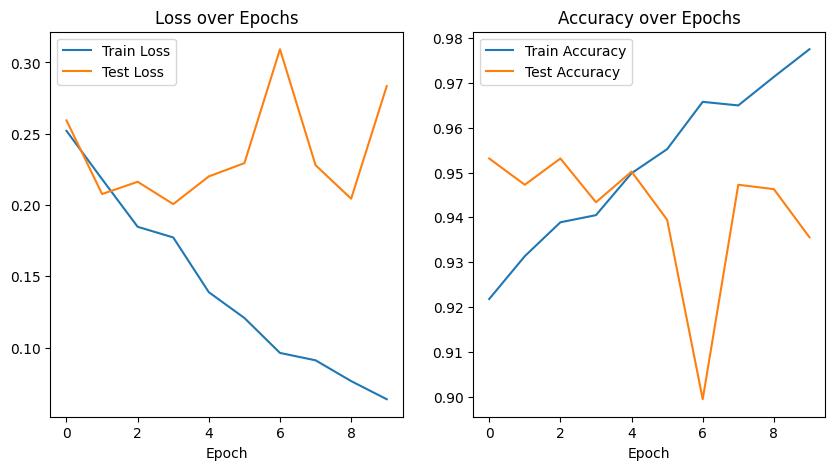

In [ ]:
# Plotting the training curve
import matplotlib.pyplot as plt

def plot_results(results_dict):
    plt.figure(figsize=(10, 5))
    epochs = range(len(results_dict["train_loss"]))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, results_dict["train_loss"], label="Train Loss")
    plt.plot(epochs, results_dict["test_loss"], label="Test Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, results_dict["train_accuracy"], label="Train Accuracy")
    plt.plot(epochs, results_dict["test_acc"], label="Test Accuracy")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

plot_results(model_0_results)

## Predicting

99%
Prediction finished!


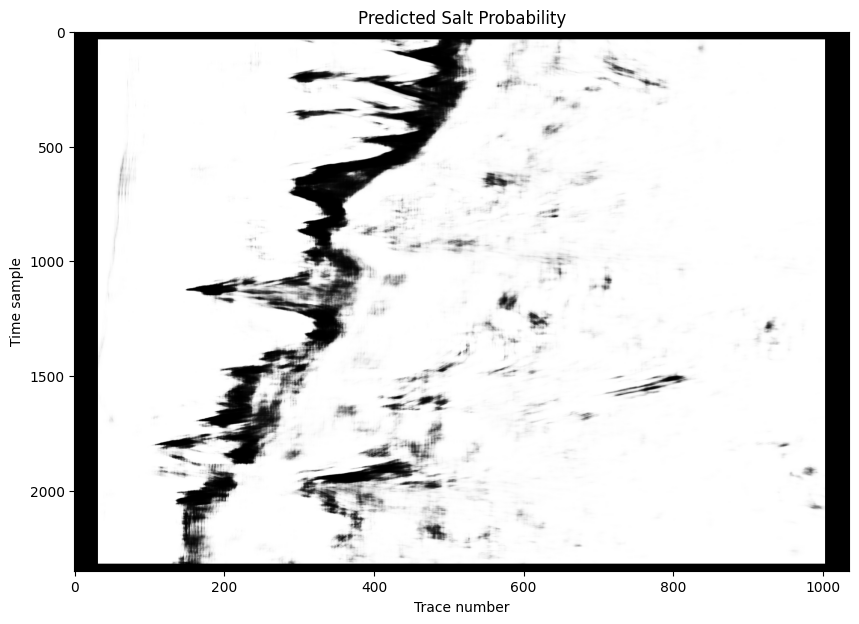

In [ ]:
# Get dimension of the fill seismic section
(t_max, x_max,_) = data.shape

# Preallocate the result array to hold model output for each pixel (2 Classes)
result = np.zeros((t_max, x_max, 2))

# Preallocate a baych array to hold input patches during inference
# batch = np.zeros((t_max - dim[1], * dim))

# Initialize progress tracker
m = 0
n = 0

# Loop over spatial (x) dimension, leaving out the edges to avoid going out of bound
for x in range(dim[0] // 2, x_max - dim[0] // 2):
  # Display progress in the console
  stdout.write(f"\r{int(m)}%")
  stdout.flush()
  m += 100 / (x_max - dim[0])

  # For each x, slide a window across the time (t) axis
  batch_patches = []
  t_indices_for_column = []
  for t in range(dim[1] // 2, t_max - dim[1] // 2):
    # Extract a patch centered at (t, x)
    patch = data[t - dim[1] // 2 : t + dim[1] // 2,
                  x - dim[0] // 2 : x + dim[0] // 2, 0]
    batch_patches.append(patch)
    t_indices_for_column.append(t)

  # Convert list of patches to numpy array
  batch_np = np.array(batch_patches)
  # Add channel dimension
  batch_tensor = torch.tensor(batch_np, dtype=torch.float32).unsqueeze(1).to(device)

  # Get prediction from the model
  model_0.eval()
  with torch.no_grad():
    pred_logits = model_0(batch_tensor)

  # Apply softmax to get probabilities and convert to numpy
  pred_probs = torch.softmax(pred_logits, dim=1).detach().cpu().numpy()

  for i, t_val in enumerate(t_indices_for_column):
        result[t_val, x, :] = pred_probs[i, :]

print("\nPrediction finished!")

# Visualize the final prediction
plt.figure(figsize=(10, 7))
# We visualize the probability of the 'salt' class (class 1)
plt.imshow(result[:, :, 0].T, cmap='gray', aspect='auto')
plt.title("Predicted Salt Probability")
plt.xlabel("Trace number")
plt.ylabel("Time sample")
plt.show()



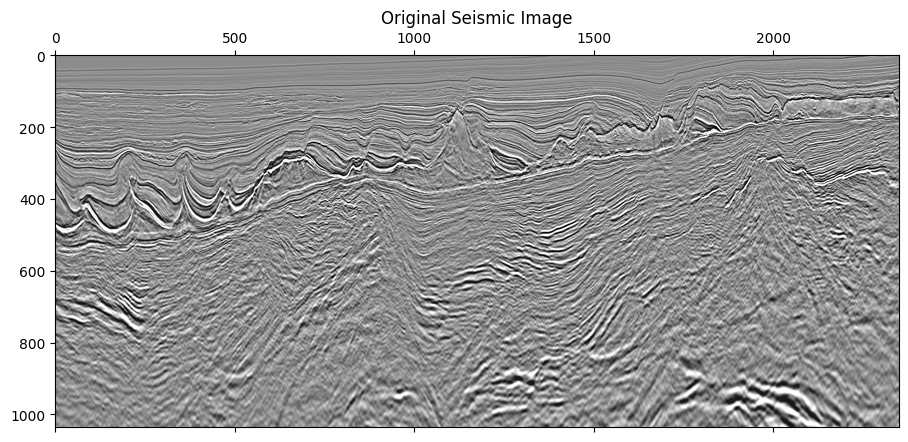

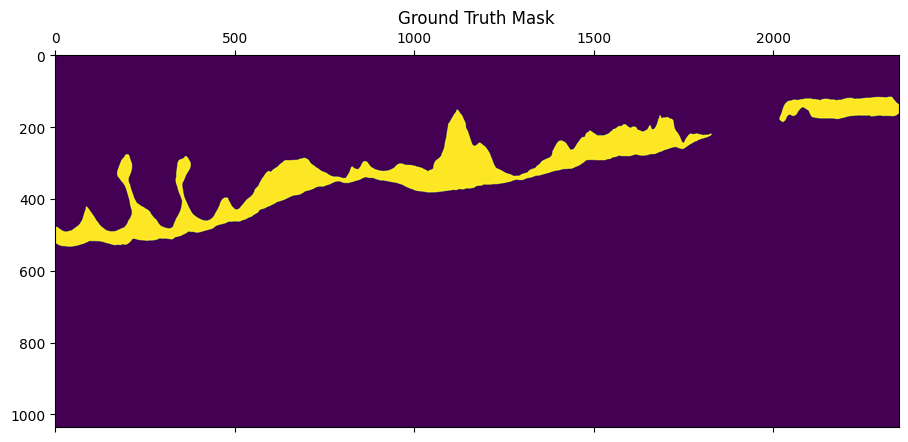

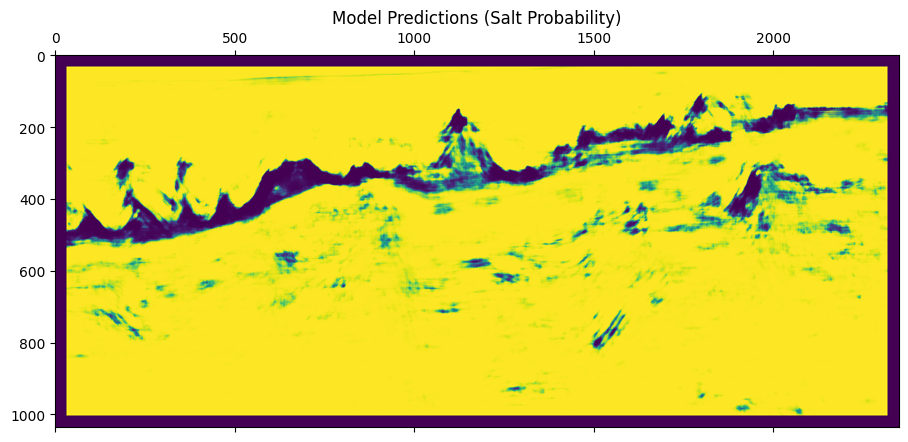

In [ ]:
# Visualize the results
# Show original seismic image
plt.matshow(data[:,:,0], interpolation = 'spline16', cmap = plt.cm.gray, aspect = 1)
plt.title("Original Seismic Image")
plt.show()

# Show ground truth mask
plt.matshow(mask, interpolation = 'spline16', aspect = 1)
plt.title("Ground Truth Mask")
plt.show()

# Show model predictions (only the 'salt) probaility channel
plt.matshow(result[:,:,0], interpolation = 'spline16', aspect = 1 )
plt.title("Model Predictions (Salt Probability)")
plt.show()